In [1]:
using_colab = True

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth

PyTorch version: 2.2.1+cu121
Torchvision version: 0.17.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ff3j8uft
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ff3j8uft
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=6ab167046f3cc6191fc663f7bcc1a824fa3e5417d5d05b162ccba5b1c92c316a
  Stored in directory: /tmp/pip-ephem-wheel-cache-svgxpeir/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-05-02 12:02:04--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

In [3]:

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [5]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [24]:
# image = cv2.imread('/content/drive/MyDrive/HOLE_Detection/Antisolvent_none_2_8.jpg')
image = cv2.imread('/content/drive/MyDrive/HOLE_Detection/Temp 50-150_130C2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

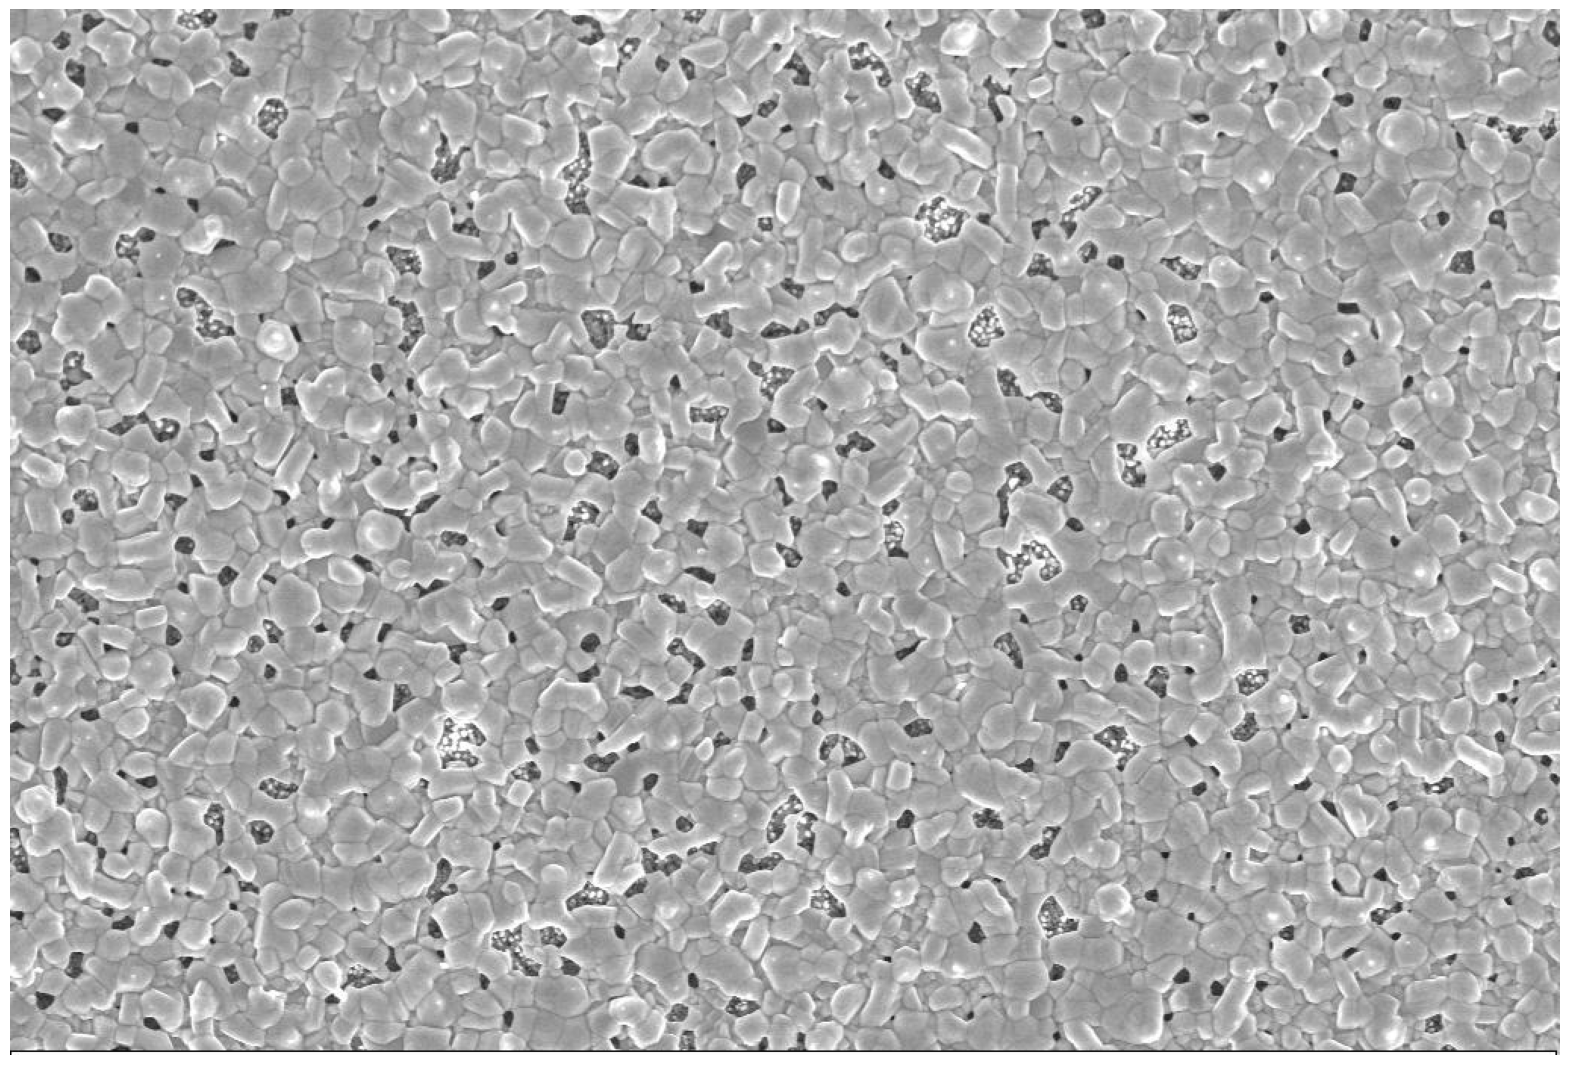

In [25]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [20]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_l_0b3195.pth"
model_type = "vit_l"

device = torch.device("cuda")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [11]:
masks = mask_generator.generate(image)

In [12]:
print(len(masks))
print(masks[0].keys())

232
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [13]:
plt.figure(figsize=(15,15))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [26]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=52,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=60,  # Requires open-cv to run post-processing
)

In [27]:
masks2 = mask_generator_2.generate(image)
len(masks2)

2028

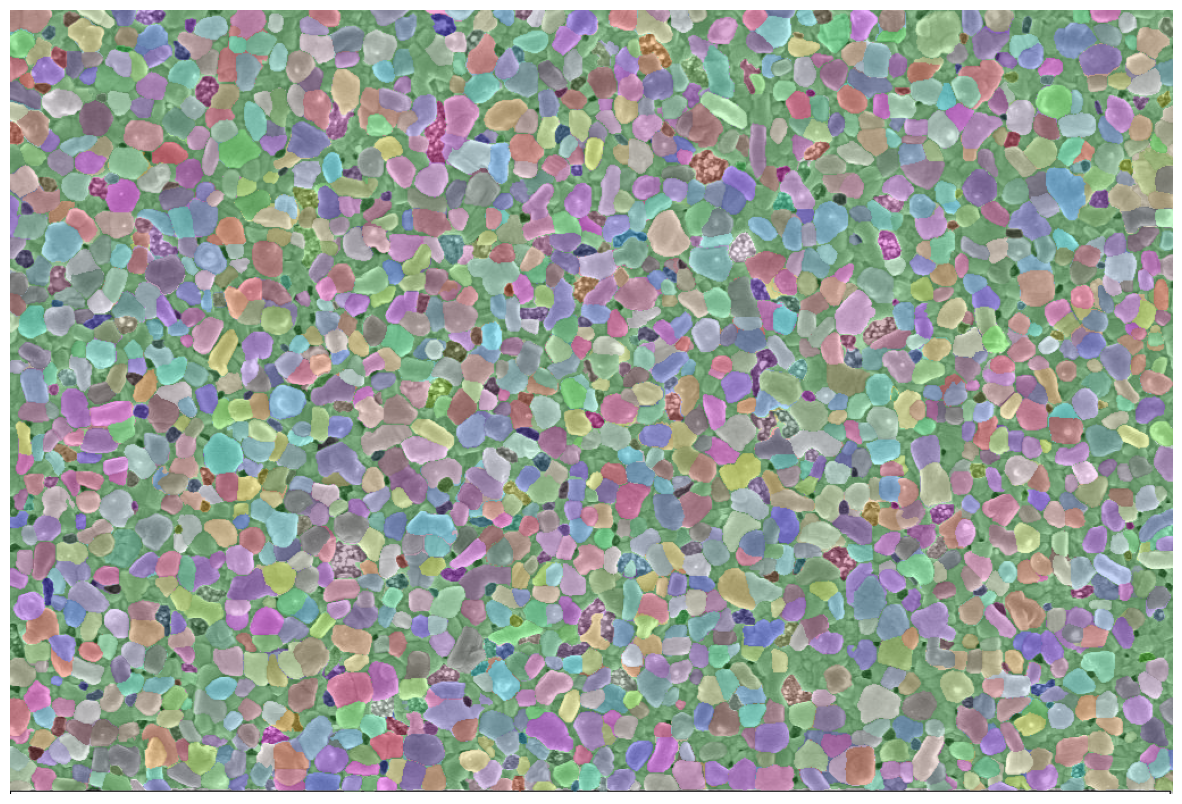

In [28]:
plt.figure(figsize=(15,15))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

## K-NN

In [ ]:
import numpy as np
import cv2
from sklearn.cluster import KMeans

# Assuming 'masks' is a list of masks generated by SAM and 'image' is the original image

# Function to calculate the average pixel intensity of the masked area
def average_intensity(image, mask):
    masked_image = cv2.bitwise_and(image, image, mask=mask.astype(np.uint8))
    return np.mean(masked_image[mask > 0])

# Compute average pixel intensity for each mask
avg_intensities = [average_intensity(image, mask['segmentation']) for mask in masks2]

# Reshape avg_intensities for KMeans
features = np.array(avg_intensities).reshape(-1, 1)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(features)

# Cluster labels for each mask
labels = kmeans.labels_

# Separate masks into two clusters
cluster_1_masks = [masks2[i] for i in range(len(masks2)) if labels[i] == 0]
cluster_2_masks = [masks2[i] for i in range(len(masks2)) if labels[i] == 1]

# Optional: Determine which cluster corresponds to darker regions
# You can compare the cluster centers to decide this
cluster_centers = kmeans.cluster_centers_
darker_cluster_index = 0 if cluster_centers[0] < cluster_centers[1] else 1
darker_masks = cluster_1_masks if darker_cluster_index == 0 else cluster_2_masks

# Now, 'darker_masks' contains the masks covering the darkest regions of the image


In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(darker_masks)
plt.axis('off')
plt.show()

## NEw KNN

In [17]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def filter_masks_by_size(masks, image, max_size):
    """
    Filters masks based on their size to remove very small and very large masks.
    min_size and max_size should be defined based on the domain knowledge about the grain sizes.
    """
    filtered_masks = []
    total_pixels = image.shape[0] * image.shape[1]
    for mask in masks:
        mask_size = np.sum(mask['segmentation'])
        if mask_size <= max_size:
            filtered_masks.append(mask)
    return filtered_masks

def calculate_circularity(mask):
    area = np.sum(mask)
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        perimeter = cv2.arcLength(contours[0], True)
        if perimeter == 0:
            return 0
        circularity = 4 * np.pi * (area / (perimeter ** 2))
    else:
        circularity = 0
    return circularity
def average_intensity(image, mask):
    masked_image = cv2.bitwise_and(image, image, mask=mask.astype(np.uint8))
    return np.mean(masked_image[mask > 0])

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def apply_kmeans(masks, image):
    avg_intensities = [average_intensity(image, mask['segmentation']) for mask in masks]
    features = np.array(avg_intensities).reshape(-1, 1)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(features)
    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    darker_cluster_index = 0 if cluster_centers[0] < cluster_centers[1] else 1
    darker_masks = [masks[i] for i in range(len(masks)) if labels[i] == darker_cluster_index]
    lighter_masks = [masks[i] for i in range(len(masks)) if labels[i] != darker_cluster_index]
    return darker_masks,lighter_masks



def show_masks(image, masks,title="Masks"):
    plt.figure(figsize=(20, 20))
    plt.imshow(image)
    show_anns(masks)
    plt.title(title)
    plt.axis('off')
    plt.show()

def resolve_overlaps(masks):
    keep_masks = []
    n = len(masks)
    removed = set()

    for i in range(n):
        if i in removed:
            continue
        current_mask = masks[i]['segmentation']
        max_area = np.sum(current_mask)
        best_mask = masks[i]

        for j in range(i + 1, n):
            if j in removed:
                continue
            compare_mask = masks[j]['segmentation']
            if calculate_iou(current_mask, compare_mask) > 0.5:  # Threshold for considering an overlap
                if np.sum(compare_mask) > max_area:
                    max_area = np.sum(compare_mask)
                    removed.add(i)
                    best_mask = masks[j]
                    current_mask = compare_mask
                else:
                    removed.add(j)

        keep_masks.append(best_mask)

    return keep_masks





# Assuming masks and image are defined
darker_masks1, lighter_masks1 = apply_kmeans(masks, image)
darker_masks2, lighter_masks2 = apply_kmeans(masks2, image)
# Combine and resolve overlaps for darker masks
combined_darker_masks = darker_masks1 + darker_masks2
non_overlapping_darker = resolve_overlaps(combined_darker_masks)
show_masks(image, non_overlapping_darker, "Darker Masks")

# Calculate and display properties for lighter masks
combined_lighter_masks = lighter_masks1 + lighter_masks2
non_overlapping_lighter = resolve_overlaps(combined_lighter_masks)
max_size = 0.1 * image.shape[0] * image.shape[1]   # Example: 10% of the image area
filtered_lighter_masks = filter_masks_by_size(non_overlapping_lighter, image, max_size)
show_masks(image, filtered_lighter_masks, "Lighter Masks")




Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def calculate_coverage_percentage(image, masks):
    total_pixels = image.shape[0] * image.shape[1]  # Total number of pixels in the image
    mask_area_sum = sum(np.sum(mask['segmentation']) for mask in masks)  # Sum the areas of all masks
    coverage_percentage = (mask_area_sum / total_pixels) * 100  # Convert to percentage
    return coverage_percentage
coverage_percentage = calculate_coverage_percentage(image, non_overlapping_darker)
print(f"Percentage of the image covered by masks: {coverage_percentage:.2f}%")

Percentage of the image covered by masks: 5.70%


In [ ]:
# Calculate average size and circularity for lighter masks
average_size = np.mean([np.sum(mask['segmentation']) for mask in filtered_lighter_masks])
average_circularity = np.mean([calculate_circularity(mask['segmentation']) for mask in filtered_lighter_masks])

print("Average size of lighter masks:", average_size)
print("Average circularity of lighter masks:", average_circularity)

Average size of lighter masks: 1466.2592592592594
Average circularity of lighter masks: 0.7246816431253407


In [ ]:
import os
def rename_files(directory):
    # List all files in the directory
    for filename in os.listdir(directory):
        if "Copy" in filename:
            # Define the new filename
            new_filename = filename.replace("Copy of ", "")
            # Get full file paths
            old_file = os.path.join(directory, filename)
            new_file = os.path.join(directory, new_filename)
            # Rename the file
            os.rename(old_file, new_file)
            print(f"Renamed '{filename}' to '{new_filename}'")

# Path to the directory containing files (adjust as needed)
folder_path = '/content/drive/MyDrive/HOLE_DET_REM2'
rename_files(folder_path)

Renamed 'Copy of Spinspeed 4000 vs 6000_4000_IPA_1_2.jpg' to 'Spinspeed 4000 vs 6000_4000_IPA_1_2.jpg'
Renamed 'Copy of Spinspeed 4000 vs 6000_4000_IPA_2_1.jpg' to 'Spinspeed 4000 vs 6000_4000_IPA_2_1.jpg'
Renamed 'Copy of Spinspeed 4000 vs 6000_4000_IPA_2_4.jpg' to 'Spinspeed 4000 vs 6000_4000_IPA_2_4.jpg'
Renamed 'Copy of Spinspeed 4000 vs 6000_4000_3.jpg' to 'Spinspeed 4000 vs 6000_4000_3.jpg'
Renamed 'Copy of Spinspeed 4000 vs 6000_4000_1.jpg' to 'Spinspeed 4000 vs 6000_4000_1.jpg'
Renamed 'Copy of Spinspeed 4000 vs 6000_4000_IPA_1_4.jpg' to 'Spinspeed 4000 vs 6000_4000_IPA_1_4.jpg'
Renamed 'Copy of Spinspeed 4000 vs 6000_4000_IPA_2_2.jpg' to 'Spinspeed 4000 vs 6000_4000_IPA_2_2.jpg'
Renamed 'Copy of Spinspeed 4000 vs 6000_4000_IPA_1_3.jpg' to 'Spinspeed 4000 vs 6000_4000_IPA_1_3.jpg'
Renamed 'Copy of Spinspeed 4000 vs 6000_4000_2.jpg' to 'Spinspeed 4000 vs 6000_4000_2.jpg'
Renamed 'Copy of Spinspeed 4000 vs 6000_4000_IPA_1_1.jpg' to 'Spinspeed 4000 vs 6000_4000_IPA_1_1.jpg'
Rename